In [1]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.model_selection
import sklearn.metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from fairness import fairestimator, utils
np.random.seed(42)

# Introducing The IgnoringBiasEstimator
Recently, I heard of a friend of mine, 26 years old, who was interviewing for a resident position (_"arts in opleiding tot specialist (aios)"_ in Dutch). Everything went well and she got the position. But she did tell me one specificic part of the conversation that just blew my mind: when planning her educational program for the next ten years, the dean just planned her maternity leave with it. And while she told this as only a somewhat weird incident, I was flabbergasted. The thing is: I probably shouldn't have been. Many female friends have similar experiences.

Now this blog is about AI, but AI is about the real world. In the real world, many biases lead to uneven outcomes. In the story above, my friend did get the position, but in many instances, groups may be disadvantaged. While there is a lot of attention for bias mitigation in AI, I feel it is still lacking: it requires more work, gives worse outcomes and less flexibility. To me, this is unacceptable. I work for the organisation I do, because I feel it helps society. Therefore, I developed an easy wrapper around `sklearn`-models that mitigates biases. I call it the **IgnoringBiasEstimator**. It has the following advantages:
* It is **extremely easy to implement**, as it is just a wrapper around sklearn models that are ubiquitous in data science. We will investigate this in this blog.
* It is **very flexible**: unlike many bias mitigation algorithms, it works with both regression and classification and for both continuous and binary/categorical. We will look into this further in further installments of the series.
* Most importantly, it **removes disparate treatment very well**,  also when the bias is non-linear and/or correlated, which we will also investigate further in next installments.
* As a bonus, it **gives insight in the current biases** in the data set, which may be used to decrease the bias in the real world as well. 

What the algorithm does is learn the bias during training time, and then ignores this bias at prediction time.

In this notebook, I will first generate a biased data set, and show how that can lead to biased models, and how and why just ignoring the sensitive attributes does not solve the problem. After that, I will quickly show how to run the the IgnoringBiasEstimator and how well it does both in terms of fairness and accuracy. A deeper investigation will follow in parts 2 and 3. 


## Generating biased data: salaries for employees

To investigate fairness, we generate a toy dataset. It consists of three employee characteristics: Gender (0 or 1), Education (between 4 and 20) and Experience, a continuous variable between 0 and 40. It also has a SalaryTrue column, which is the monthly salary of each employee.

![image info](./Figures/DGP_Salary_Uncorrelated.png "The data generating process for salary for an imaginary company with biases in employee salaries")

Imagine there is a company that is concerned with salary differences, and they set out to give everyone a fair salary, but with the same mean salary. The SalarySkill column contains what should be paid to each employee, if the salary were based purely on the skill. It is based on Education (150 per level) and experience (30 per level), with a standard deviation of 150 per employee for other characteristics. Unfortunately, in the true world, we do not observe this - we only observe the paid salary. 

Now imagine this company has a gender bias, where the people with gender 1 are structurally paid less 200 every month. This is what is observed in the SalaryTrue column.

In [2]:
true_world_values = pd.Series({'Education': 150, 'Experience': 30, 'Gender': -200, 'Intercept': 100}, name='TrueWorldValues')
skill_base_values = pd.Series({'Education': 150, 'Experience': 30, 'Gender': 0, 'Intercept': 0}, name='SkillBasedValues')

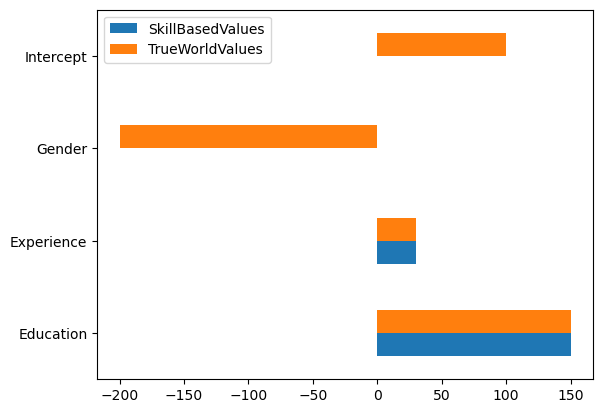

In [3]:
coefficients = pd.concat([skill_base_values,
                          true_world_values,
                          ], axis='columns'
                         )
coefficients.plot(kind='barh')
plt.show()

*Note that the intercept is 100 larger in the True world so that the same mean salary is paid for the entire company.*

In [4]:
def generate_employees_uncorrelated(size=2500):
    X = (pd.DataFrame({'Gender': np.random.randint(2, size=size),
                       'Education': 4 + 16 * np.random.rand(size),
                       'Experience': 40*np.random.rand(size)
                      }
                     )         
        )
    return X

def add_salaries(df):
    weights = {'Gender': 0,
               'Education': 150,
               'Experience': 30,
              }
    gender_bias = -200
    error = np.random.normal(0, 150, size=len(df))
    df = df.assign(SalarySkill = lambda df: df.mul(weights).sum('columns').add(error),
                   SalaryTrue = lambda df: df['SalarySkill'].add(df['Gender'].sub(0.5).mul(gender_bias)))
    return df

In [5]:
df = generate_employees_uncorrelated().pipe(add_salaries)
def display_age_df(df, n=10):
    display(df.sample(n, random_state=42)
              .style.format({'Education': "{:.2f}", 'Experience': '{:.2f}',
                             'SalarySkill': "€{:.2f}", 'SalaryTrue': '€{:.2f}'})
        )

display_age_df(df)

,Gender,Education,Experience,SalarySkill,SalaryTrue
1447,1,8.99,2.55,€1589.80,€1489.80
1114,0,13.24,12.55,€2692.03,€2792.03
1064,1,19.89,30.78,€3756.35,€3656.35
2287,0,9.69,34.95,€2585.75,€2685.75
1537,1,7.15,2.01,€1254.20,€1154.20
668,0,10.26,13.41,€2003.52,€2103.52
1583,1,8.62,12.13,€1789.53,€1689.53
2404,0,4.49,7.49,€1253.32,€1353.32
497,1,8.16,4.82,€1466.47,€1366.47
2480,0,6.41,23.14,€1374.16,€1474.16


## Training a model on biased data gives biased outcomes
### No mitigation just propagates biases
Now the company sets out to predict salaries for all employees - first making a nice train and test split, and then fitting and validating a model

In [6]:
(X_train, X_test, y_train, y_test,
 y_skill_train, y_skill_test) = sklearn.model_selection.train_test_split(df.filter(['Education', 'Experience', 'Gender', ]),
                                                                                                         df['SalaryTrue'],
                                                                                                         df['SalarySkill'])

In [7]:
lr = LinearRegression()
lr.fit(X_train, y_train)

print(f'The mean absolute error of the fitted model is {sklearn.metrics.mean_absolute_error(lr.predict(X_test), y_test): .2f} ')

The mean absolute error of the fitted model is  122.26 


## Fairness is a matter of definition: disparate impact vs. disparate treatment
That looks very good, for such a simple model. But is it fair? Well, that depends on the definition of fairness. While I will not dive too deep in all definitions (for more, see e.g. [here](https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb), we need to define two different concepts:
* **Disparate treatment** is when a decision process, such as an algorithm, makes different decisions based on sensitive attributes, such as gender or age.
* **Disparate impact** is when a decision process, such as an algorithm, leads to different outcomes for some sensitive attributes.

There may be a disparate impact without disparate treatment if the sensitive attribute correlates with other, important features - we will see this in a bit.

Disparate impact is easiest to show. We can plot both the mean predicted salary and erorr for both groups:

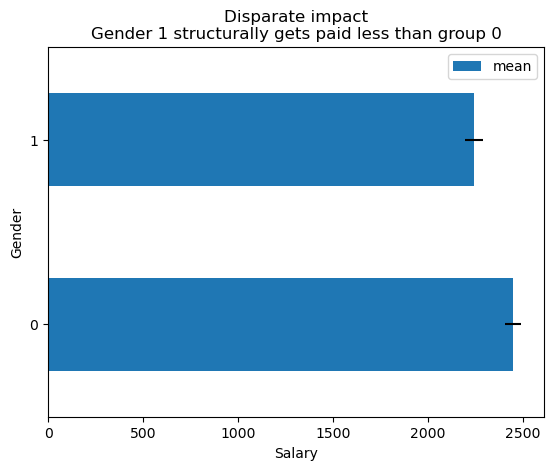

In [8]:
y_pred = utils.predict_series(lr, X_test)
y_pred_per_gender = y_pred.groupby(X_test['Gender']).agg(['mean', 'sem'])
ax = y_pred_per_gender.plot(y='mean', xerr='sem', kind='barh', title='Disparate impact\nGender 1 structurally gets paid less than group 0')
ax.set_xlabel('Salary')
plt.show()

In this case, there is definitely a disparate impact. That in itself, may already be enough to find the algorithm is unfair, others may argue that experience and level of education are valuable to the company and that in fact should pay more. Therefore, let's quickly look into disparate treatment as well.

In this case, we see that has a negative coefficient of -200 for gender 1 (closely mimicking the real, biased world), so there is a disparate treatment.

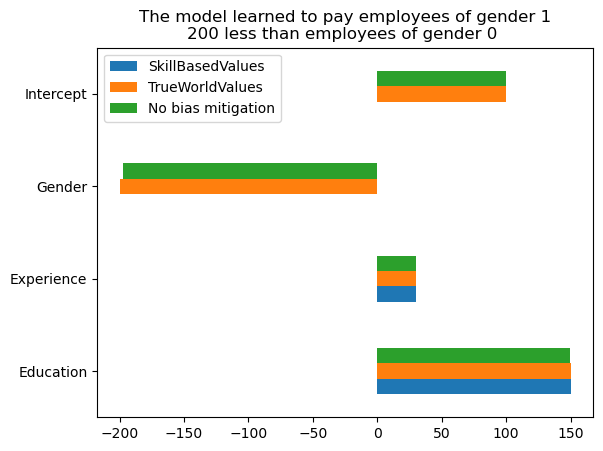

In [9]:
coefficients['No bias mitigation'] = utils.coefs_to_series(lr, X_train.columns.tolist())
coefficients.plot(kind='barh', title='The model learned to pay employees of gender 1\n200 less than employees of gender 0 ')
plt.show()

We can also show both Disparate impact and Disparate treatment in the plot below. The Disparate impact is just the difference between the pay in Gender 1 and Gender 2. But because we generated the data, we also have access to the salary based purely on skills (which we generally do not in a real world scenario). The difference between the means between the skills-based salary and the predicted salary is the Disparate treatment. Again, we see the model suffers from both disparate impact and disparate treatment.

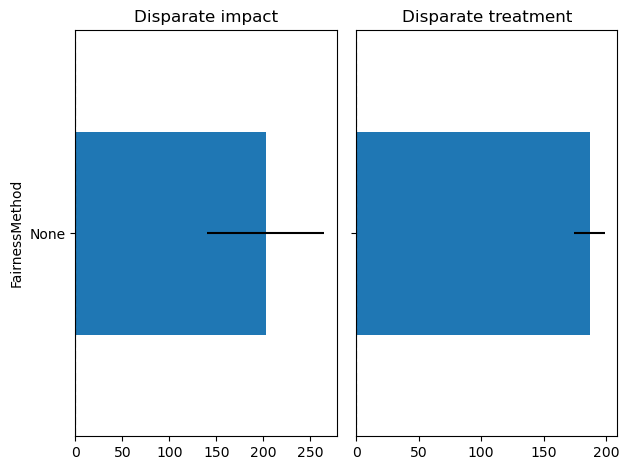

In [10]:
predictions = {'None': y_pred,
                }

utils.plot_fairness_metrics(predictions, y_skill_test, X_test['Gender'])
plt.show()

## A generally inadequate bias mitigation approach: Unawareness
One way of dealing with this is 'Unawareness': drop the protected attributes and fit the model without it, so it does not account for the protected attribute.

In [11]:
X_train_unaware = X_train.drop(columns=['Gender'])
X_test_unaware = X_test.drop(columns=['Gender'])

In [12]:
lr_unaware = LinearRegression()
lr_unaware.fit(X_train_unaware, y_train)
print(f'The mean absolute error of the fitted model is {sklearn.metrics.mean_absolute_error(lr_unaware.predict(X_test_unaware), y_test): .2f} ')


The mean absolute error of the fitted model is  149.43 


At the cost of a bit of accuracy, we now have a model that does not take Gender into account. Let's see what this does with out fairness measures.

In [13]:
y_pred_unaware = utils.predict_series(lr_unaware, X_test_unaware)

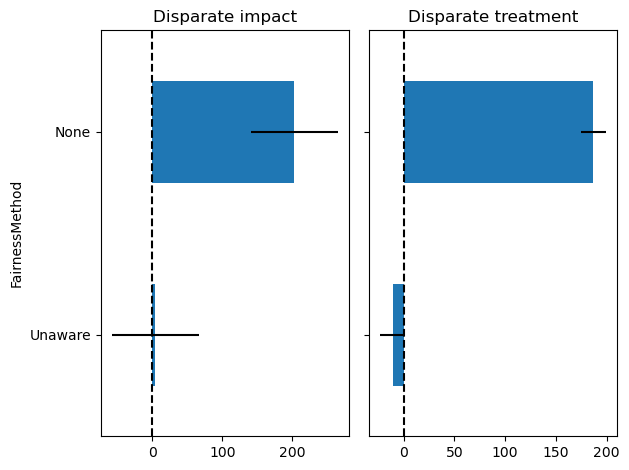

In [14]:
predictions = {'None': y_pred,
               'Unaware': y_pred_unaware,
                }

utils.plot_fairness_metrics(predictions, y_skill_test, X_test['Gender'])
plt.show()

So for this case, it seems we now have a fair model on both metrics.
### This toy dataset is unrealistic because there are no correlations
However, unawareness is insufficient because in the real world the protected attribute often correlates with other, non-protected and perhaps even relevant attributes. For the toy dataset we have, we have completely uncorrelated samples, which is unrealistic.

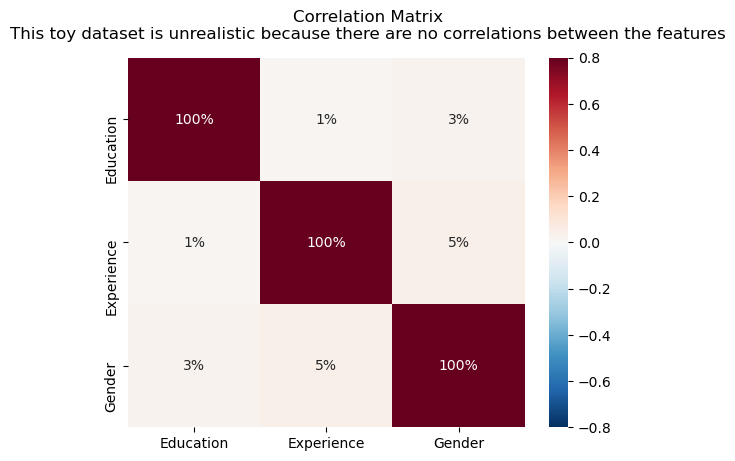

In [15]:
sns.heatmap(X_train.corr(), cmap='RdBu_r', vmin=-0.8, vmax=0.8, annot=True, fmt='.0%')
plt.suptitle('Correlation Matrix\nThis toy dataset is unrealistic because there are no correlations between the features')
plt.show()

## Unawareness only solves the problem for trivial toy datasets
In this part we will show that neither approach works if the protected attribute is in fact correlated with other attributes. This is almost always the case in real life, and often in very complicated ways.

For our example, let's investigate a simple case where due to societal expectations and developments a gender that is disadvantaged is also biased against in getting education and experience, as shown in the following process:

![image info](./Figures/DGP_Salary_Correlated.png "The data generating process for salary for an imaginary company with biases in employee salaries, where experience and education correlate with gender")


In [16]:
def generate_employees_correlated(size=2500):
    '''
    Generating employees, where attributes are correlated with gender
    
    Gender 1 generally has lower education and experience
    '''
    X = (pd.DataFrame({'Gender': np.random.randint(2, size=size),})
           .assign(Education = lambda df: 4 + 16 * np.random.rand(size) * np.where(df['Gender'] == 0, 1, np.random.rand(size)) ,
                   Experience = lambda df: (40*np.random.rand(size) + np.random.normal(df['Gender'].mul(-1).add(1).mul(10), 5)).clip(0, 40),
                  )
         
        )
    return X


In [17]:
df_corr = generate_employees_correlated().pipe(add_salaries)
display_age_df(df_corr)

,Gender,Education,Experience,SalarySkill,SalaryTrue
1447,0,16.21,40.00,€3927.44,€4027.44
1114,1,4.23,19.89,€1184.13,€1084.13
1064,1,14.80,20.63,€3007.49,€2907.49
2287,1,4.20,20.39,€1278.24,€1178.24
1537,0,4.25,29.69,€1632.36,€1732.36
668,0,18.64,19.81,€3281.88,€3381.88
1583,1,15.09,22.20,€3191.39,€3091.39
2404,0,5.21,22.85,€1260.05,€1360.05
497,1,4.01,38.34,€1802.39,€1702.39
2480,1,16.45,9.37,€2721.91,€2621.91


In [18]:
X_corr_train, X_corr_test, y_corr_train, y_corr_test, y_corr_skill_train, y_corr_skill_test = sklearn.model_selection.train_test_split(
                                                                                                         df_corr.filter(['Education', 'Experience', 'Gender', ]),
                                                                                                         df_corr['SalaryTrue'],
                                                                                                         df_corr['SalarySkill'])
X_corr_train_unaware = X_corr_train.drop(columns=['Gender']) # So we can train an unaware regressor
X_corr_test_unaware = X_corr_test.drop(columns=['Gender'])

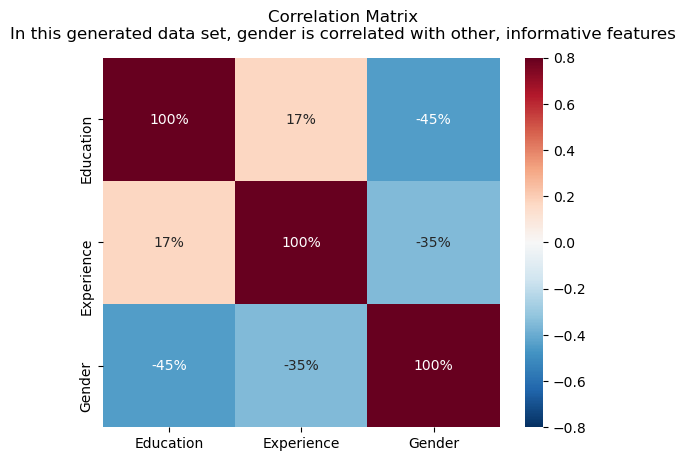

In [19]:
sns.heatmap(X_corr_train.corr(), cmap='RdBu_r', vmin=-0.8, vmax=0.8, annot=True, fmt='.0%')
plt.suptitle('Correlation Matrix\nIn this generated data set, gender is correlated with other, informative features')
plt.show()

In [20]:
lr = LinearRegression()
lr.fit(X_corr_train, y_corr_train)
y_corr_pred = utils.predict_series(lr, X_corr_test)

In [21]:
lr_unaware = LinearRegression()
lr_unaware.fit(X_corr_train_unaware, y_corr_train)
y_corr_pred_unaware = utils.predict_series(lr_unaware, X_corr_test_unaware)

While the bias is not as bad in the model when explicitly allowing for the dependency, it is still clearly there, with people of gender 1 getting ~50 less per month based on their gender. 

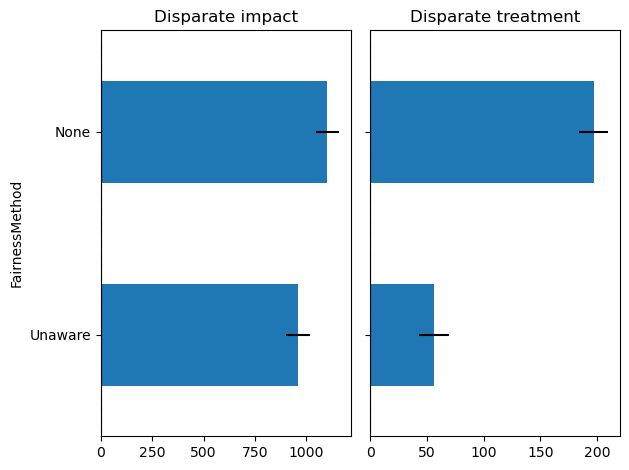

In [22]:
predictions = {'None': y_corr_pred,
               'Unaware': y_corr_pred_unaware,
                }

utils.plot_fairness_metrics(predictions, y_corr_skill_test, X_corr_test['Gender'])
plt.show()

### Unawareness compensates the lack of direct information through correlated variables
How is this possible if the model is unaware of Gender? The model _overestimates_ the importance of Experience and Education and through this keeps the biases partially intact. To keep the same mean salary, it also has a negative intercept: everyone is paid less, and then people with higher experience and education (mostly of Gender 1) are compensated.

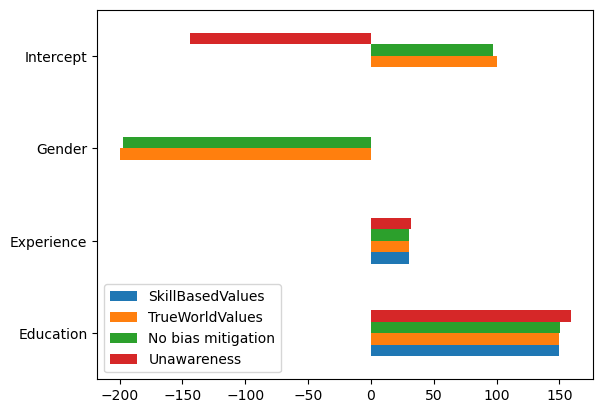

In [23]:
coefficients['No bias mitigation'] = utils.coefs_to_series(lr, X_corr_train.columns.tolist())
coefficients['Unawareness'] = utils.coefs_to_series(lr_unaware, X_corr_train_unaware.columns.tolist())

coefficients.plot(kind='barh')
plt.show()

## Removing the disparate treatment through postprocessing: learning the biases in the data and ignoring them at prediction
There are generally 3 moments to work towards fairness
* During **preprocessing** by transforming the dataset in such a way that downstream estimators learn in a fair way. Note that dropping protected attributes was in this category (in a very naive way), but much more sophisticated approaches exist. A great advantage is that you no longer need the protected attributes after this is done, but it generally does not reach the performance (both in terms of fairness and accuracy) of the other approaches.
* During **training** by modifying the estimator (be it a classifier or a regressor) and the loss function (or constraints for this). This is generally harder from a technical perspective, but may reach very good results for a given definition of fairness. 
* During **postprocessing**, which is the most flexible, but as a drawback does require access to protected attributes at test time. We will investigate this further

What we will do here is a combination of the two approaches we applied above:
* The first model had access to the protected attribute - and we clearly saw how biased it learned to be during training
* The second model did not have access - and this was better during prediction, but had an unfortunate effect during training where it learned biases through other variables.

We will combine this by learning the biases during fitting and then *ignoring them at prediction time*. The fact that the model has access to the sensitive attributes during training prevents the model from learning the biases through other variables. Then discarding those attributes during predicting still allows us to discard the biases to work towards fairer salaries.

The IgnoringBiasEstimator is very easy to implement: it's just a wrapper around the fundamental estimator we're using (in our case, a simple LinearRegression) and we have to indicate which column has the sensitive attribute.

In [24]:
ib = fairestimator.IgnoringBiasRegressor(LinearRegression(), ignored_cols=[-1]) # Ignore the Gender at prediction time, which is encoded in the last column
ib.fit(X_corr_train, y_corr_train)

In [25]:
y_corr_pred_ic = utils.predict_series(ib, X_corr_test)

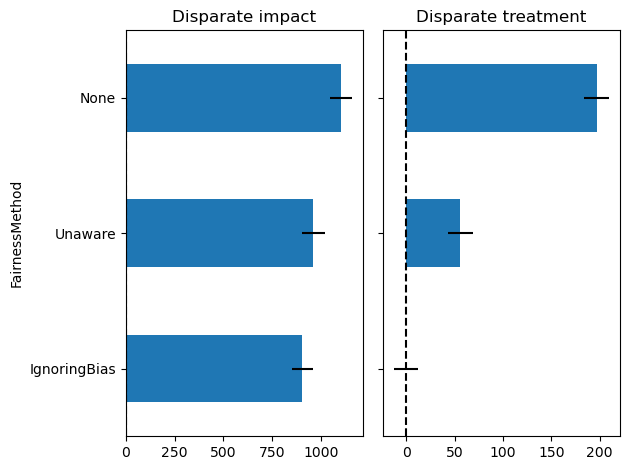

In [26]:
predictions = {'None': y_corr_pred,
               'Unaware': y_corr_pred_unaware,
               'IgnoringBias': y_corr_pred_ic}
utils.plot_fairness_metrics(predictions, y_corr_skill_test, X_corr_test['Gender'])
plt.show()

With ignoring columns, we have removed the disparate treatment: two employees of equal experience and education will receive an equal salary. For some people or use cases, that might be the definition of fair. For others, it might not be: there is still a disparate impact where employees of Gender 1 get a lower salary of ~900 a month, due to their lower experience and education on average, which may in turn be driven by societal biases.

What you should note though, is that is a choice, and you cannot have it both ways. Below, we train a model that has a Disparate Impact of 0. This on the other hand leads to a disparate treatment towards employees of gender 0: for equal experience and education, they would now receive a lower salary. There is no fundamental good or bad - this is a matter of vision.

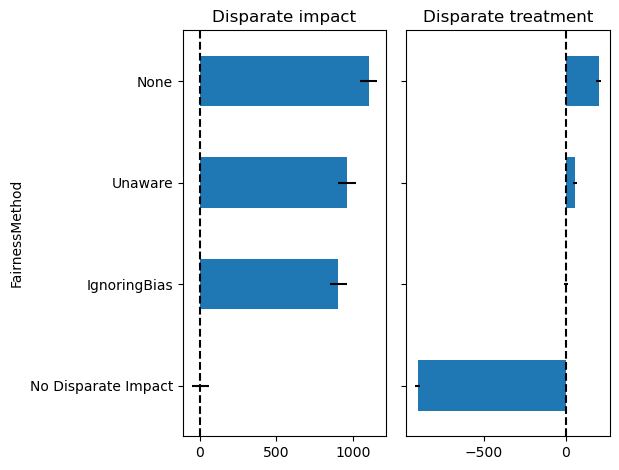

In [31]:
lr_di = copy.deepcopy(lr)
lr_di.coef_[2] = 900
y_corr_pred_di = utils.predict_series(lr_di, X_corr_test)

predictions = {'None': y_corr_pred,
               'Unaware': y_corr_pred_unaware,
               'IgnoringBias': y_corr_pred_ic,
               'No Disparate Impact': y_corr_pred_di}
utils.plot_fairness_metrics(predictions, y_corr_skill_test, X_corr_test['Gender'])
plt.show()

## Fairness does not hurt the true accuracy
In a lot of places it is statet that there is a trade-off beteween fairness and accuracy. I do not agree. The trade-off is only there because we do not observe what we would like to observe. Improving fairness you might decrease the _observed_ accuracy (which would still be worth it), but we do not _want_ to match the observed salaries in the first place - the whole point was to remove the biases that we see in the real world. In fact, we will show that the predictions of match the skills-based salaries _better_ when improving fairness. The only thing is, of course, that in a real world application we would not have access to those. But it is still very important to keep in mind that accuracy only decreases because we observe bad targets.

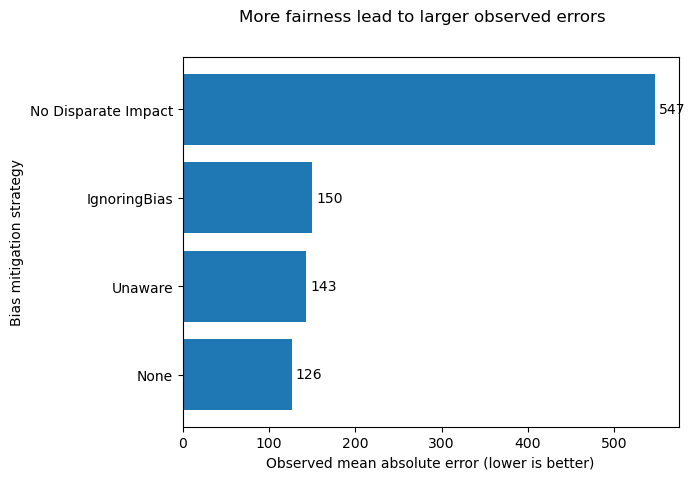

In [28]:
measurable_accuracy = {name: sklearn.metrics.mean_absolute_error(y_pred, y_corr_test) for name, y_pred in predictions.items()}
ax = plt.barh(range(len(measurable_accuracy)), measurable_accuracy.values())
plt.bar_label(ax, fmt='%d', padding=3)
plt.yticks(range(len(measurable_accuracy)), measurable_accuracy.keys())
plt.suptitle('More fairness lead to larger observed errors')
plt.ylabel("Bias mitigation strategy")
plt.xlabel('Observed mean absolute error (lower is better)')
plt.show()

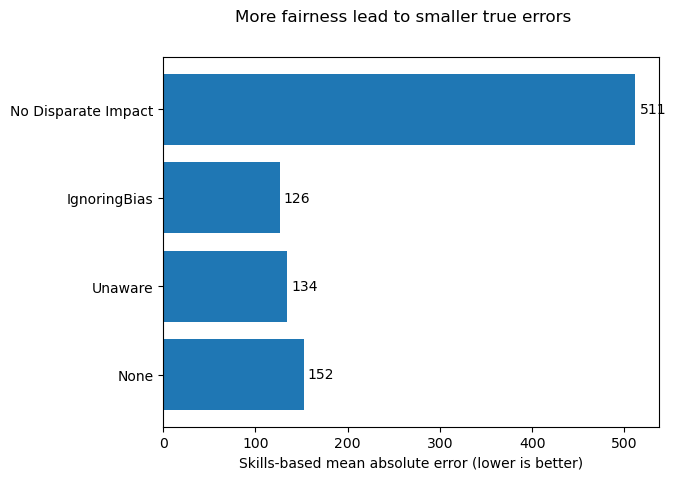

In [29]:
true_accuracy = {name: sklearn.metrics.mean_absolute_error(y_pred, y_corr_skill_test) for name, y_pred in predictions.items()}
ax = plt.barh(range(len(true_accuracy)), true_accuracy.values())
plt.bar_label(ax, fmt='%d', padding=3)
plt.suptitle('More fairness lead to smaller true errors')
plt.yticks(range(len(true_accuracy)), true_accuracy.keys())
plt.xlabel('Skills-based mean absolute error (lower is better)')
plt.show()

## Conclusion and outlook
In this blog, we saw that it was in fact very easy to remove the disparate treatment with the IgnoringBiasEstimator and that it worked very well. In the following installment of this series, I will show how flexible it is with continuous sensitive attributes and non-linear biases and classification targets. 

I hope this will contribute to more fairness in decision processes.